This notebook is first notebook out of 3 notebooks about how to use IQCELL. In this notebook we show an example of how to prepare scRNA-seq data. 

This notebook is partly based on this tutprial:

https://github.com/theislab/single-cell-tutorial

and partly based on the notebook below:

https://nbviewer.org/github/theislab/paga/blob/master/blood/nestorowa16/nestorowa16.ipynb

"PAGA for hematopoiesis in mouse [(Nestorowa *et al.*, 2016)](https://doi.org/10.1182/blood-2016-05-716480)"



Data source: [blood.stemcells.cam.ac.uk/single_cell_atlas](http://blood.stemcells.cam.ac.uk/single_cell_atlas)

In [1]:
# python libraries
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=180)  # low dpi (dots per inch) yields small inline figures
# sc.logging.print_versions()
# results_file = './write/nestorowa16.h5ad'

In [ ]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri


In [ ]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)


In [ ]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)

Read and annotate the data

In [5]:
def nestorowa16():
    # Read the data matrix.
    adata = sc.read('./nestorowa_corrected_log2_transformed_counts.txt', cache=True)
    # Read the population annotations for the cell types, obtained by gating for specific marker genes.
    cell_types = pd.read_csv('./nestorowa_corrected_population_annotation.txt', delimiter=' ')
    # Replace the long names with the acronyms and make this a vector of the length of the number of observations.
    acronyms = {'ESLAM': 'Stem', 'Erythroid': 'Ery', 'Megakaryocytes': 'Mk', 'Basophils': 'Baso',
                'Neutrophils': 'Neu', 'Monocytes': 'Mo', 'Bcell': 'B'}
    cell_types = [acronyms[cell_types.loc[cell_id, 'celltype']]
                  if cell_id in cell_types.index else 'no_gate' for cell_id in adata.obs_names]
    # Add the cell types as annotations of the cells.
    adata.obs['cell_types'] = cell_types
    return adata

## Preprocessing and basic visualization

In [7]:
adata = nestorowa16()
sc.pp.recipe_weinreb17(adata, log=False)

... reading from cache file cache/nestorowa_corrected_log2_transformed_counts.h5ad
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=50
    finished (0:00:00)


Loading the metadata of cells

In [11]:
types=pd.read_csv('all_cell_types.csv',index_col=0)
# annotate cell types
cell_cluster=[]
cells=list(list(adata.obs.index))
clusters=list(types.columns)

for cell in cells:
     number_of_clusters_to_be_in=0
     cluster=''
     type_=(types.loc[cell])
     for cl in clusters:
            if(type_[cl]==1):
                
                number_of_clusters_to_be_in=number_of_clusters_to_be_in+1
                #print( cell,' ',cl,'   ',number_of_clusters_to_be_in)
                if (number_of_clusters_to_be_in==1):
                    cluster=cluster+cl
                if (number_of_clusters_to_be_in>1):
                    cluster=cluster+'_'+cl
     if(number_of_clusters_to_be_in==0):
            cluster='NA'
     
     #print(cell,' ',cluster,'   ',number_of_clusters_to_be_in)           
     cell_cluster.append(cluster)
cell_cluster    
adata.obs['cellgate']=cell_cluster

In [12]:
pd.DataFrame(list(adata.var.index)).to_csv('current_Genes.csv')

loading the full data - all genes

In [14]:
adata_full=sc.read_h5ad('Hammey_Blood_Full_data/subsetted_adata.h5')
new_cell_names=[]
for i in list(adata_full.obs.index):
    new_cell_names.append(i.replace('-','.'))
adata_full.obs.index=new_cell_names

cells=list(adata.obs.index)
adata_full=adata_full[cells]

sc.pp.recipe_zheng17(adata_full, log=False,n_top_genes=24876)

pd.DataFrame(pd.DataFrame( list(adata_full.var.index),list(adata_full.var['Accession']) )).to_csv('all_Genes.csv')

## visualizing the data

In [16]:
sc.pp.neighbors(adata)
sc.tl.draw_graph(adata)
sc.tl.diffmap(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:10)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.97718346 0.9664374  0.94200516 0.940603   0.9297222
     0.9244626  0.91710967 0.89617103 0.8863775  0.85888636 0.82413334
     0.81650275 0.8113982  0.79876626]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_types' as categorical
/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cellgate' as categorical


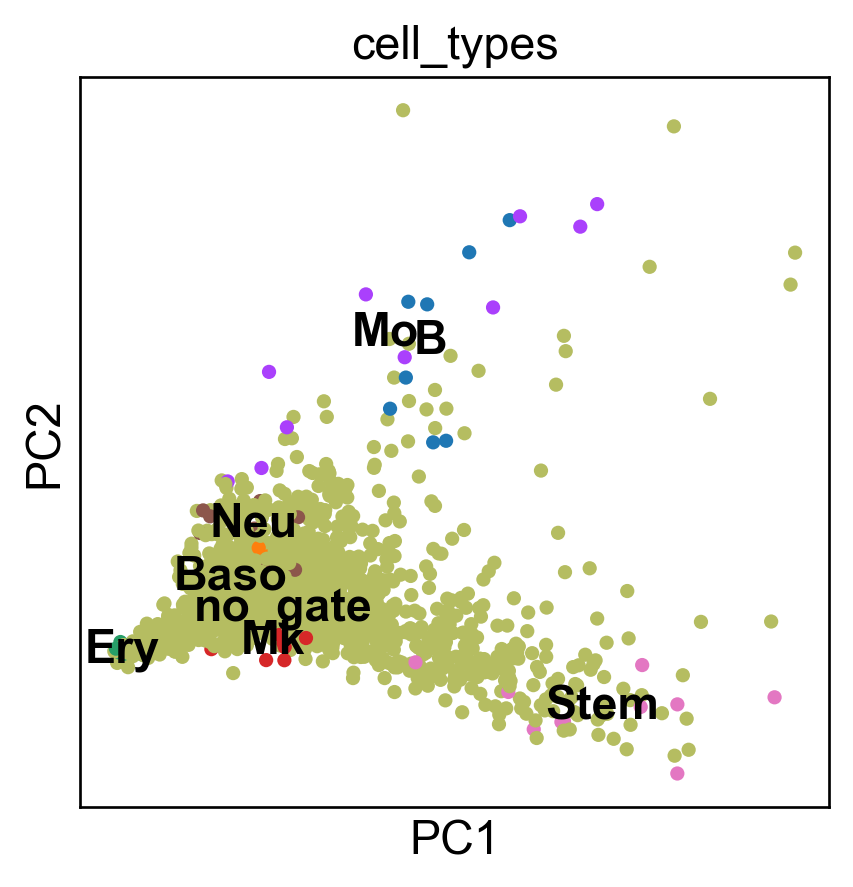

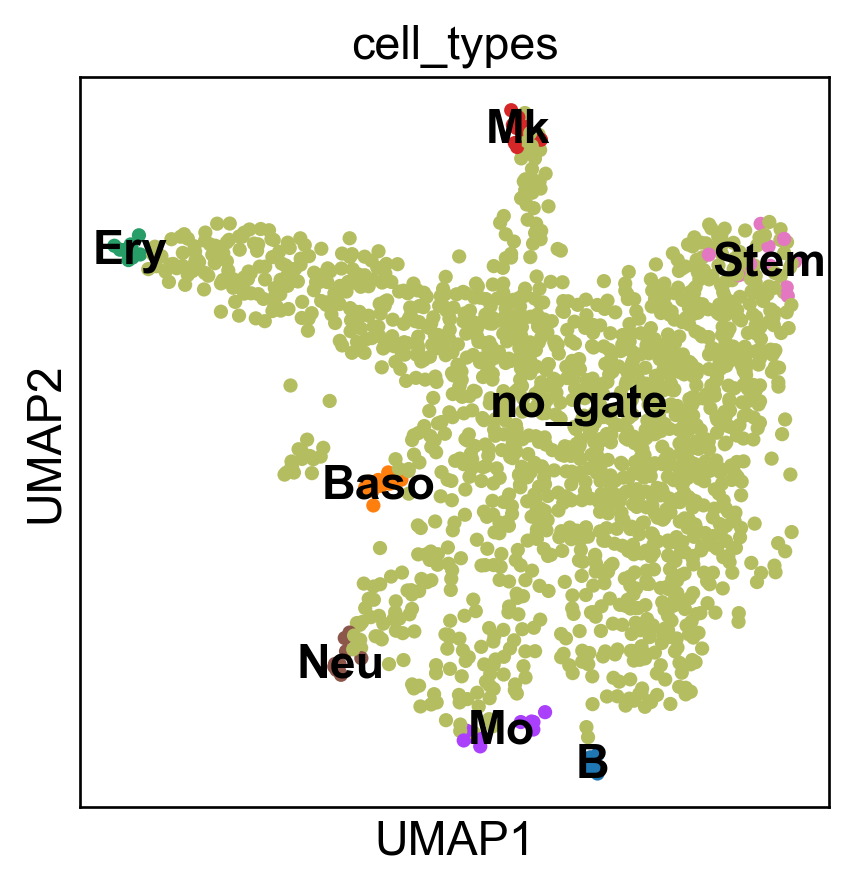

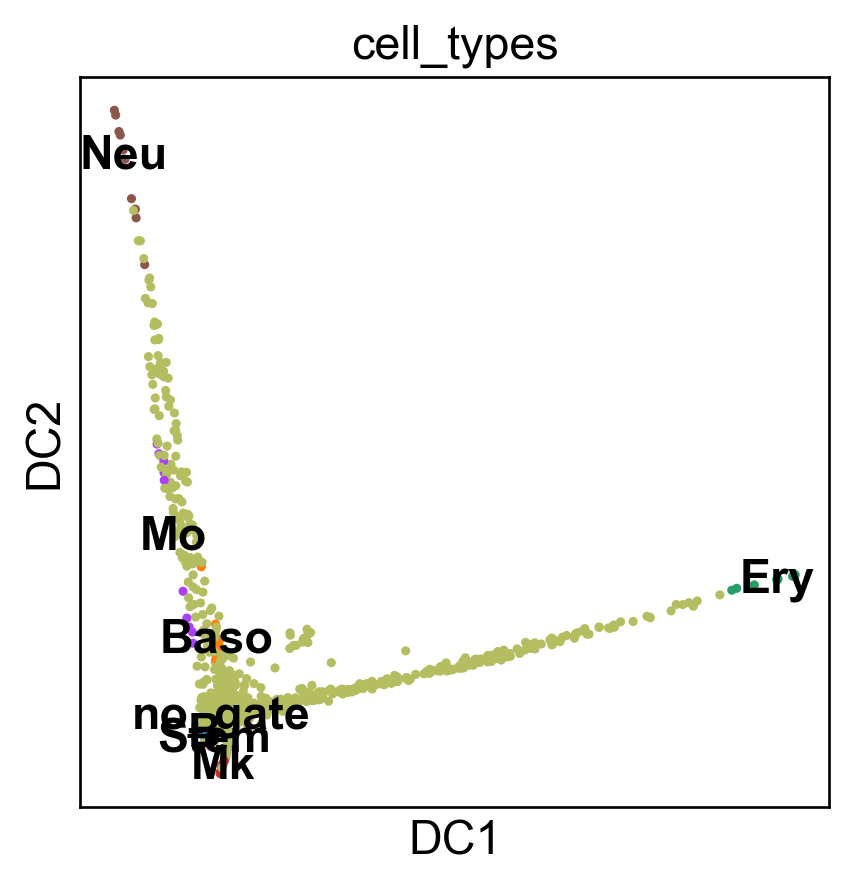

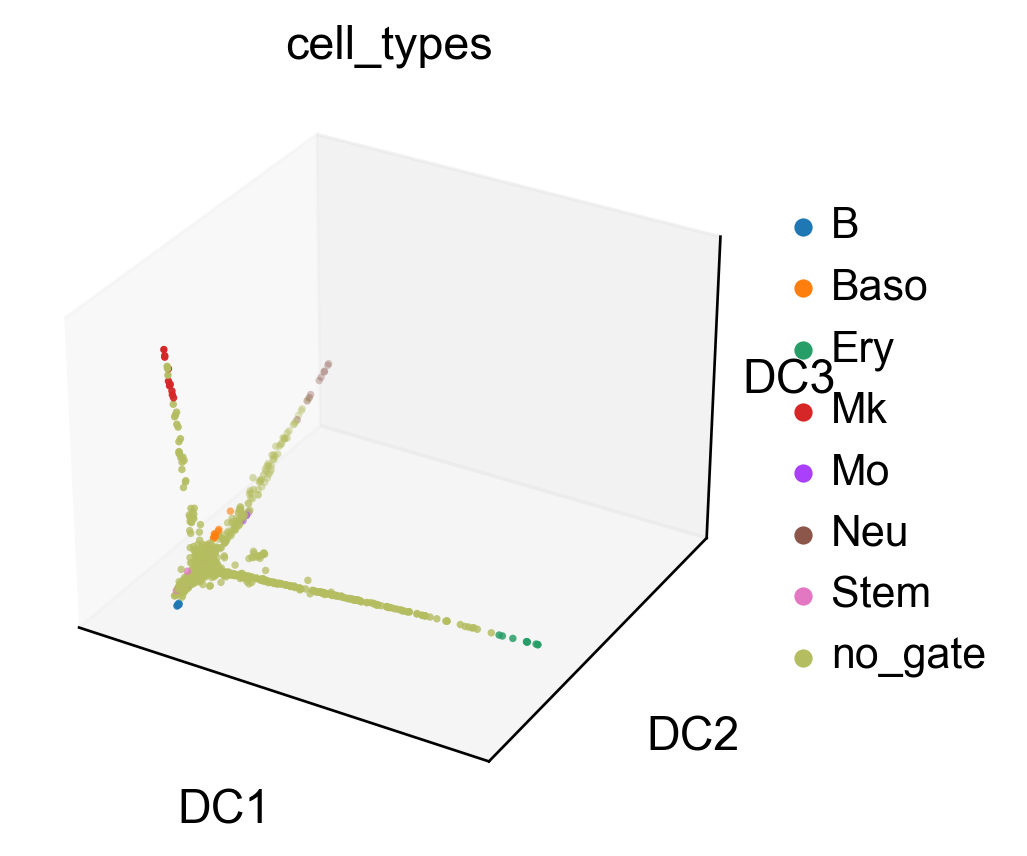

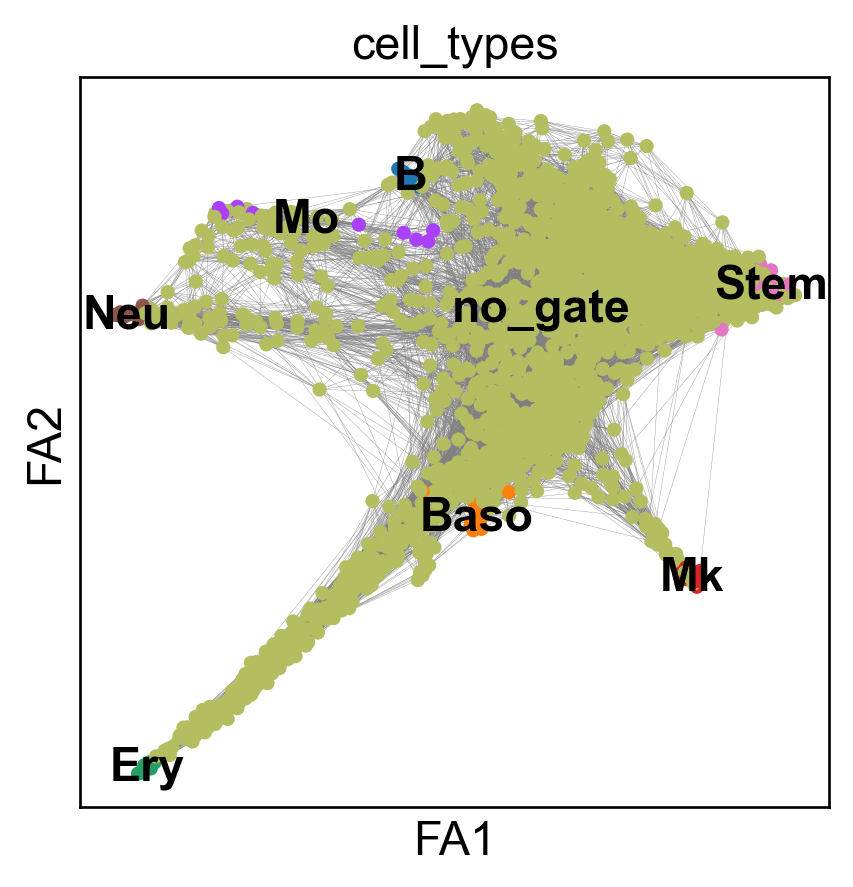

In [17]:
sc.settings.set_figure_params(dpi=120)
sc.pl.pca(adata, color='cell_types', legend_loc='on data')
sc.pl.umap(adata, color='cell_types', legend_loc='on data')
sc.pl.diffmap(adata, color='cell_types',size=30,components='1,2',legend_loc='on data')
sc.pl.diffmap(adata, color='cell_types',size=30,projection='3d')
sc.pl.draw_graph(adata, color='cell_types', edges=True, legend_loc='on data')
sc.settings.set_figure_params(dpi=80)

## Clustering

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


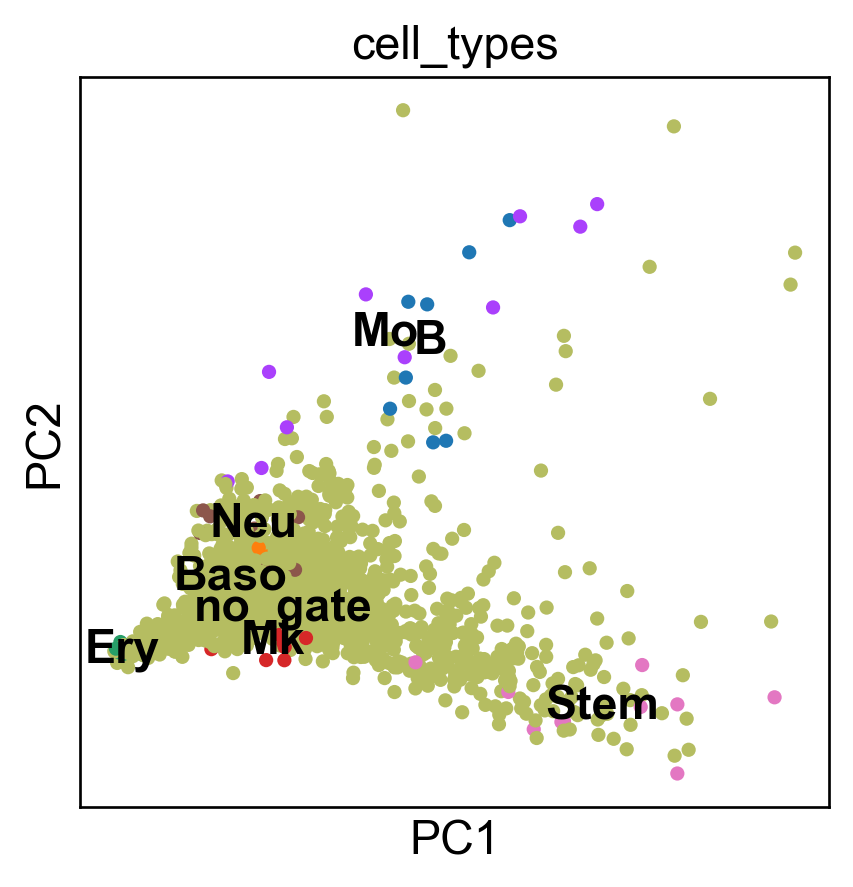

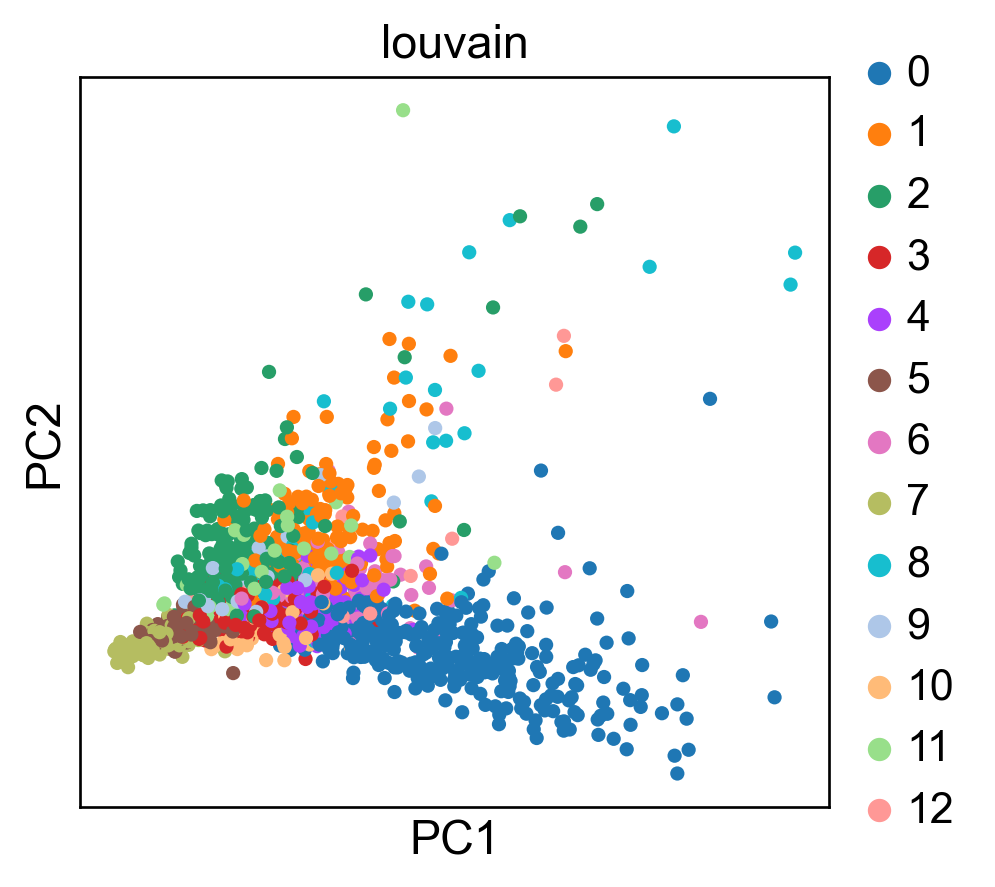

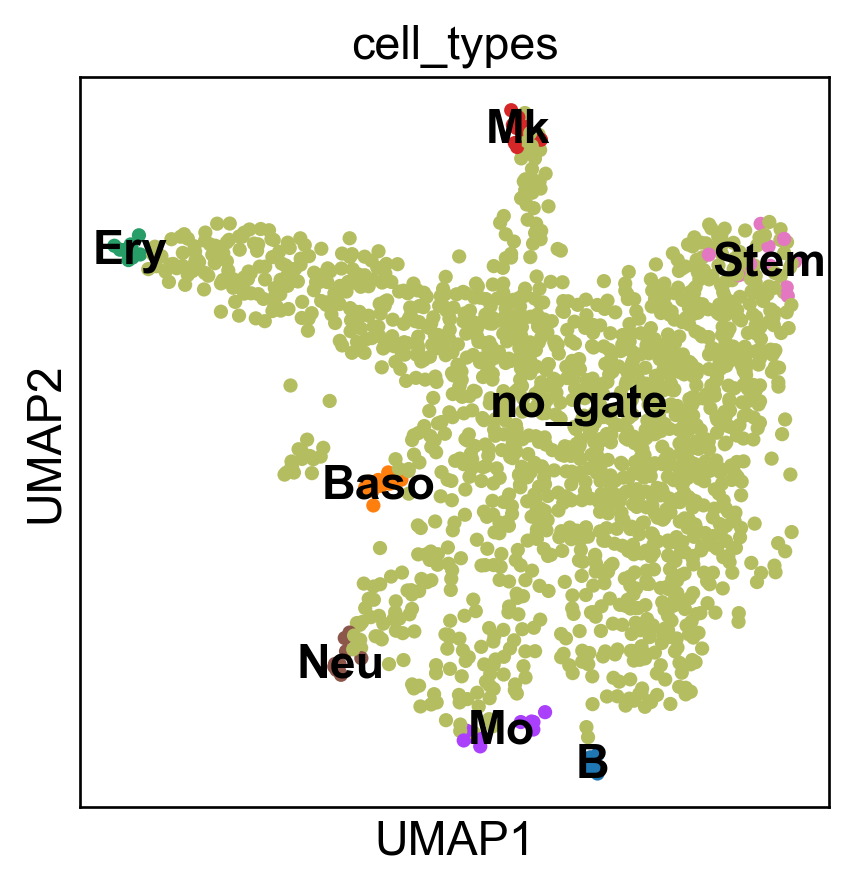

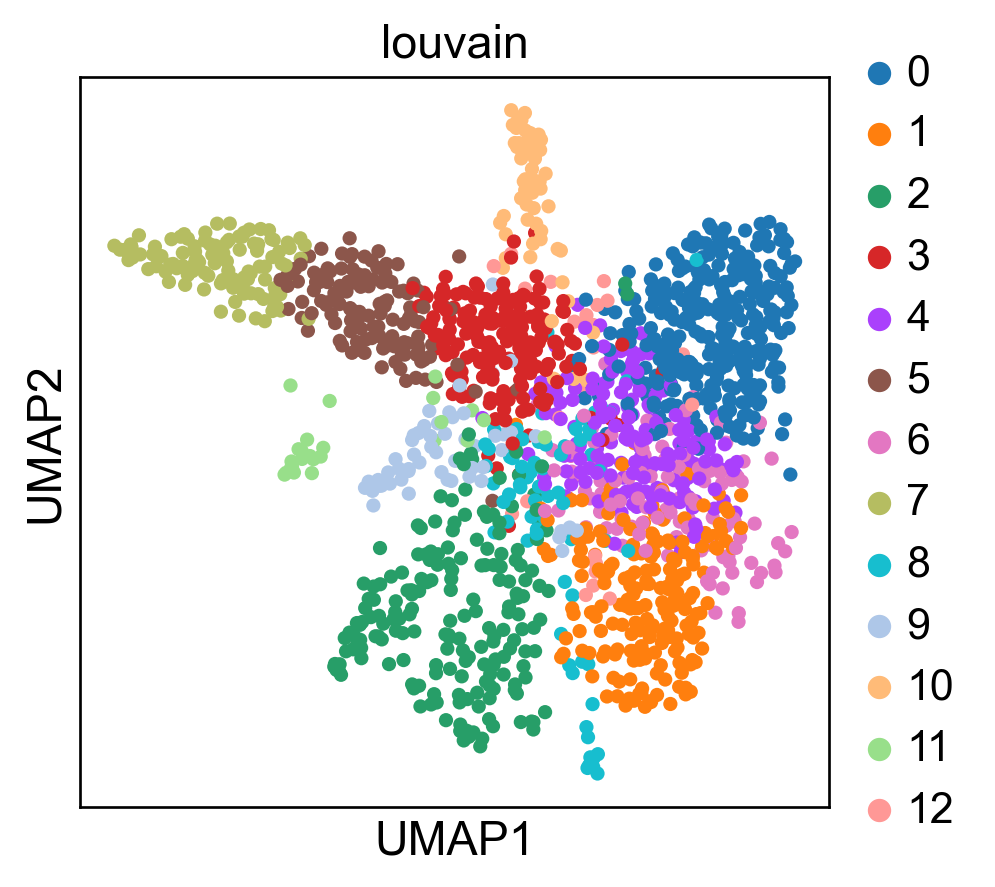

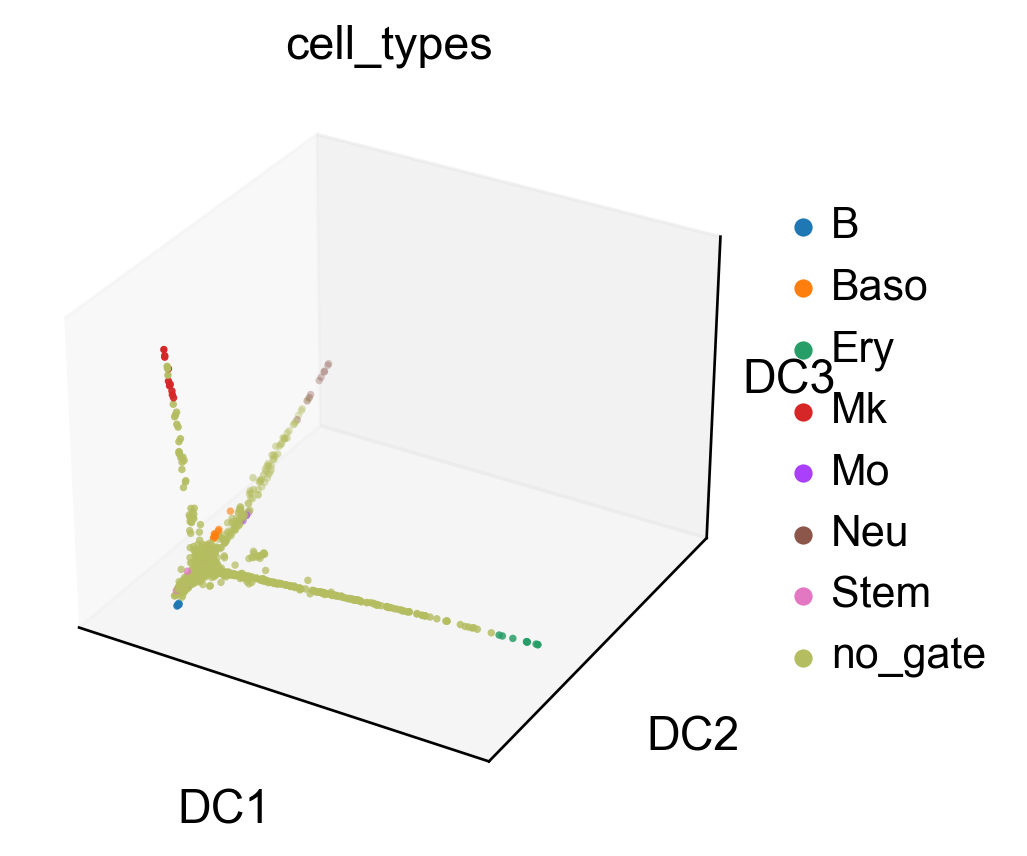

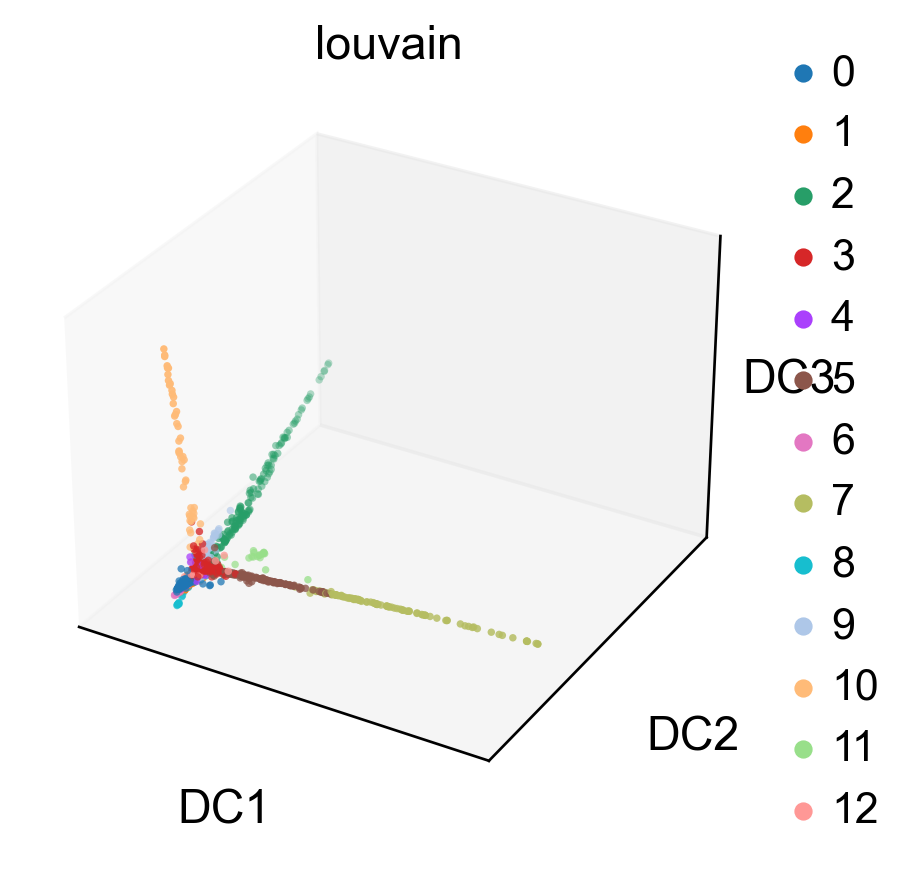

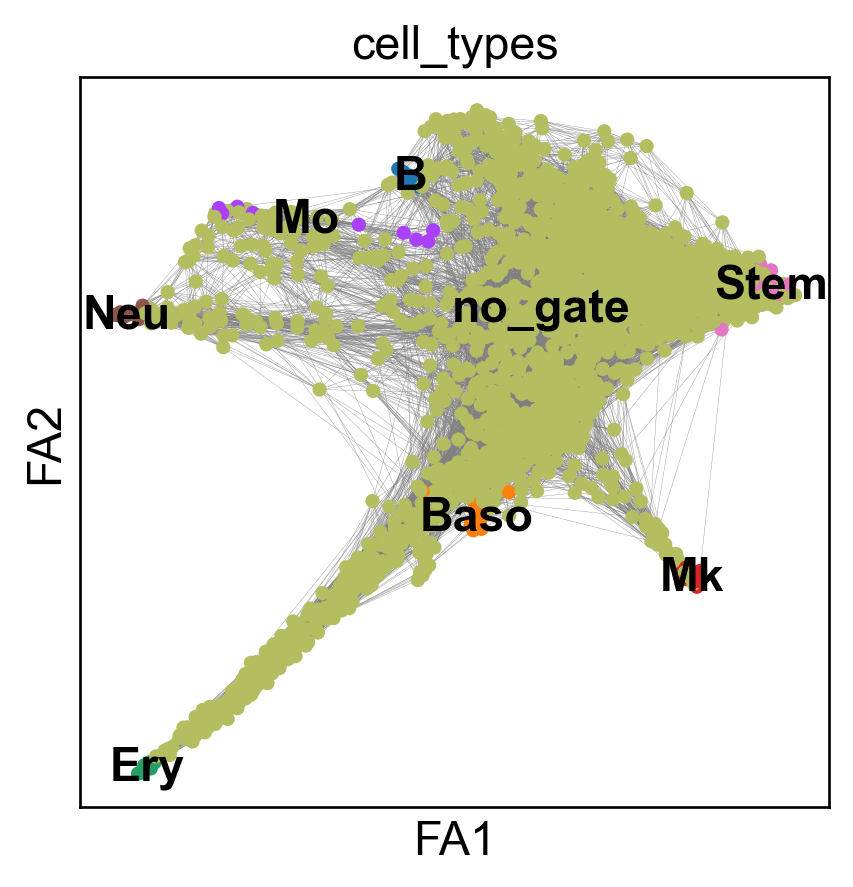

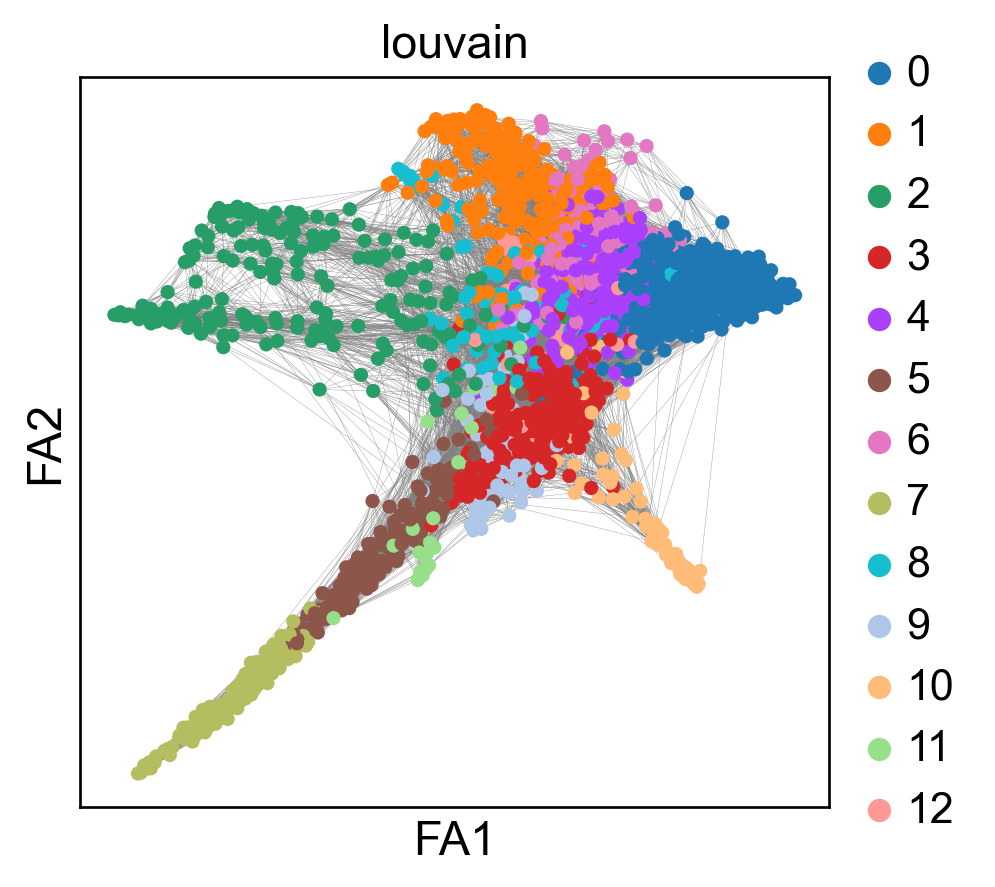

In [18]:
sc.settings.set_figure_params(dpi=120)
sc.tl.louvain(adata, resolution=1.4)

sc.pl.pca(adata, color='cell_types', legend_loc='on data')
sc.pl.pca(adata, color=['louvain'])

sc.pl.umap(adata, color='cell_types', legend_loc='on data')
sc.pl.umap(adata, color=['louvain'])

sc.pl.diffmap(adata, color='cell_types',size=30,projection='3d')
sc.pl.diffmap(adata, color=['louvain'],projection='3d')

sc.pl.draw_graph(adata, color='cell_types', edges=True, legend_loc='on data')
sc.pl.draw_graph(adata, color=['louvain'], edges=True)

In [19]:
# sc.tl.louvain(adata, resolution=0.3, restrict_to=('louvain', ['2']))
# #sc.pl.umap(adata, color=['louvain'])
# #sc.pl.umap(adata, color=['louvain_R'])

In [21]:
# #Let's annotate the clustering witht the experimental labels

# asso_names, asso_matrix = sc._utils.compute_association_matrix_of_groups(
#     adata, prediction='louvain_R', reference='cell_types', normalization='prediction')
# # the largest group is the no_gate group, appearing as '', drop the newline from the name
# asso_names = [name.replace('\n', '') if '\n' in name else str(i) for i, name in enumerate(asso_names)]

# #color_dict = dict(zip(adata.obs['cell_types'].cat.categories, adata.uns['cell_types_colors']))
# #asso_colors = [color_dict[n] if n in color_dict else 'grey' for n in asso_names]

# #Rename the groups.
# adata.obs['clusters'] = pd.Categorical(adata.obs['louvain_R'].cat.codes)
# adata.obs['clusters'].cat.categories = asso_names
# #adata.uns['clusters_colors'] = asso_colors


In [22]:
# sc.pl.pca(adata, color=['louvain_R'], legend_loc='on data')
# sc.pl.pca(adata, color=['clusters'], legend_loc='on data')

# sc.pl.umap(adata, color=['louvain_R'], legend_loc='on data')
# sc.pl.umap(adata, color=['clusters'], legend_loc='on data')

# sc.pl.diffmap(adata, color=['louvain_R'], legend_loc='on data')
# sc.pl.diffmap(adata, color=['clusters'], legend_loc='on data')

# sc.pl.draw_graph(adata, color=['louvain_R'])
# sc.pl.draw_graph(adata, color=['clusters'])

We are interested in Erythroid diffrentiation. Given the data, our stem cells are at cluster 0 and diffrentiated cells are at cluster 7:

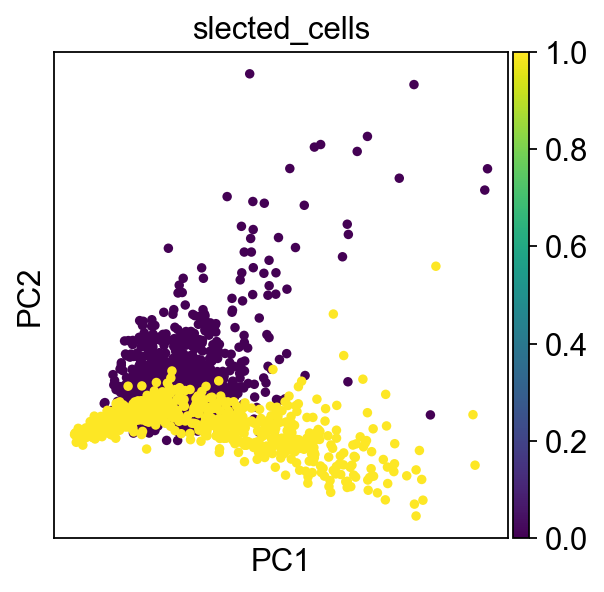

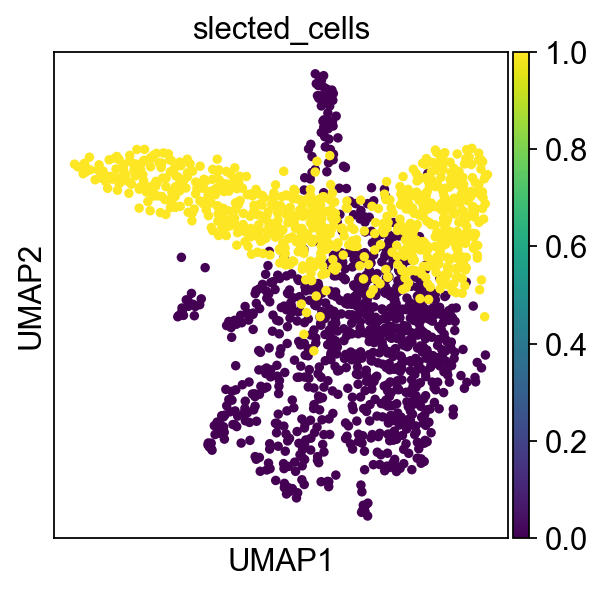

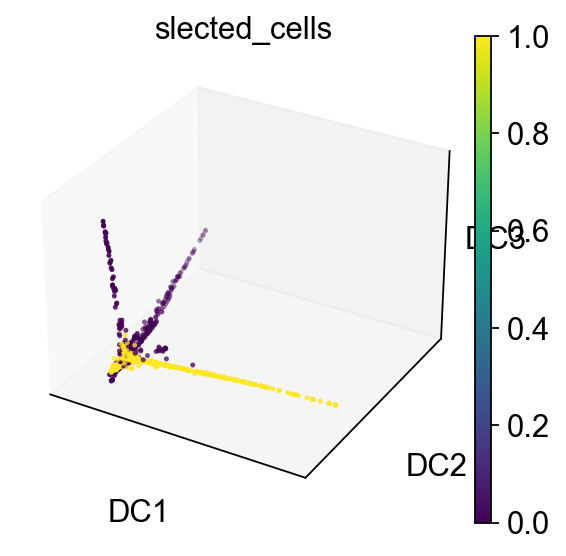

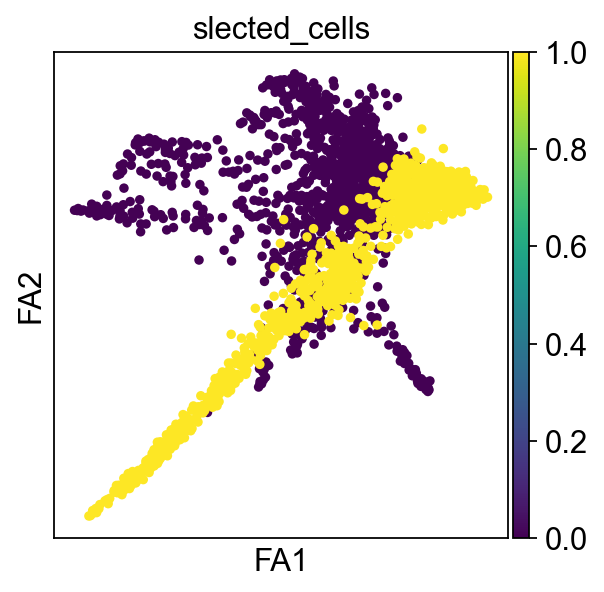

In [24]:
#select specific cluster
sc.settings.set_figure_params(dpi=80)
adata.obs['slected_cells'] =                            (adata.obs['louvain'] == ('False')) 
adata.obs['slected_cells']=adata.obs['slected_cells']+  (adata.obs['louvain'] == ('0')) 
adata.obs['slected_cells']=adata.obs['slected_cells']+  (adata.obs['louvain'] == ('3')) 
adata.obs['slected_cells']=adata.obs['slected_cells']+  (adata.obs['louvain'] == ('5')) 
adata.obs['slected_cells']=adata.obs['slected_cells']+  (adata.obs['louvain'] == ('7')) 

adata.obs['slected_cells']=adata.obs['slected_cells'] * 1
sc.pl.pca(adata, color=['slected_cells'])
sc.pl.umap(adata, color=['slected_cells'])
sc.pl.diffmap(adata, color=['slected_cells'],projection='3d')
sc.pl.draw_graph(adata, color=['slected_cells'])

In [25]:
clusters_to_include =['0','3','5','7']
adata_selected_cells = adata[np.isin(adata.obs['louvain'], clusters_to_include),:]

Now we use this selected clusters, to infer, pseudo-time using slingshot method:

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9534592  0.8690578  0.8086705  0.7388572  0.6867305
     0.6729905  0.6501882  0.6449834  0.6408913  0.6336583  0.62699175
     0.62368387 0.61917347 0.616867  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:02)
running PAGA
    finished: added


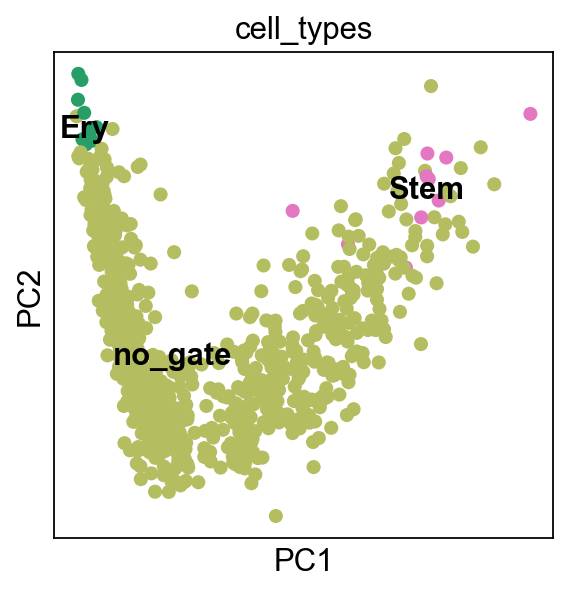

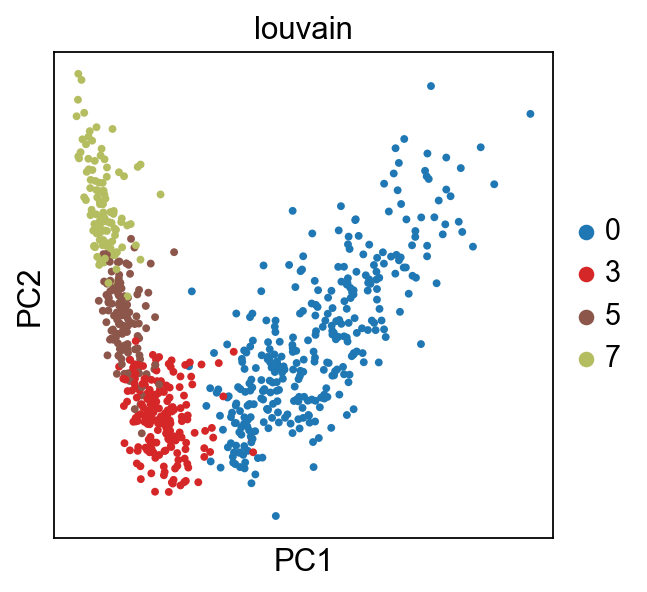

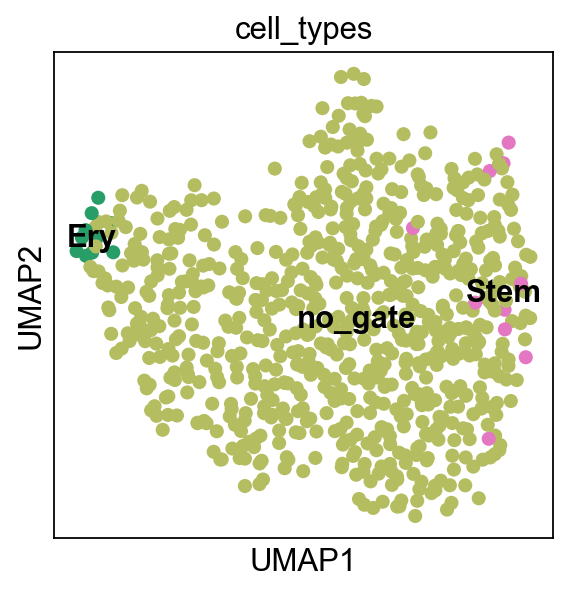

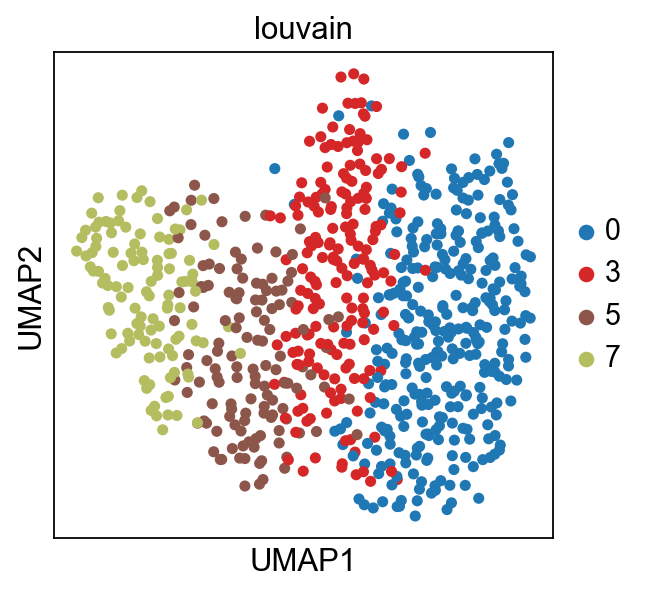

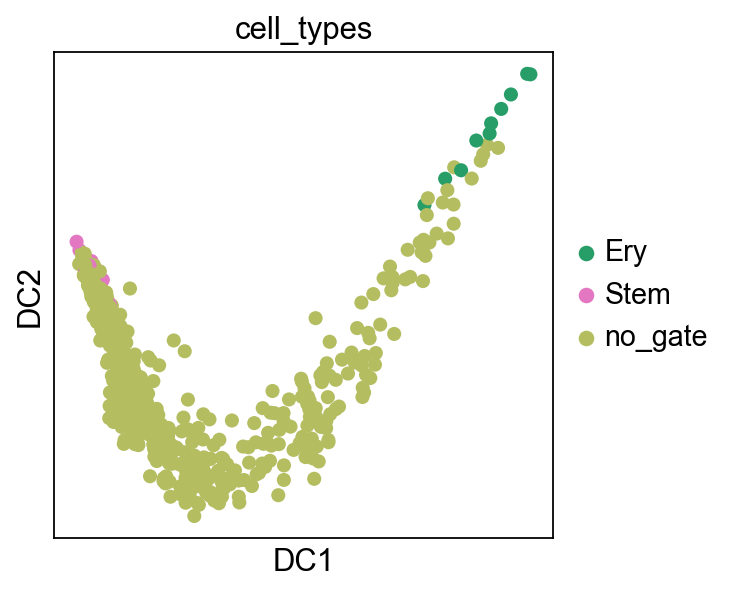

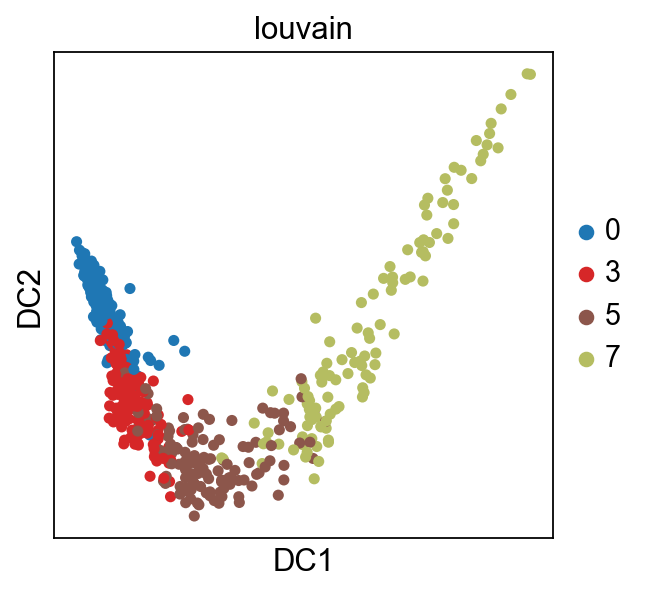

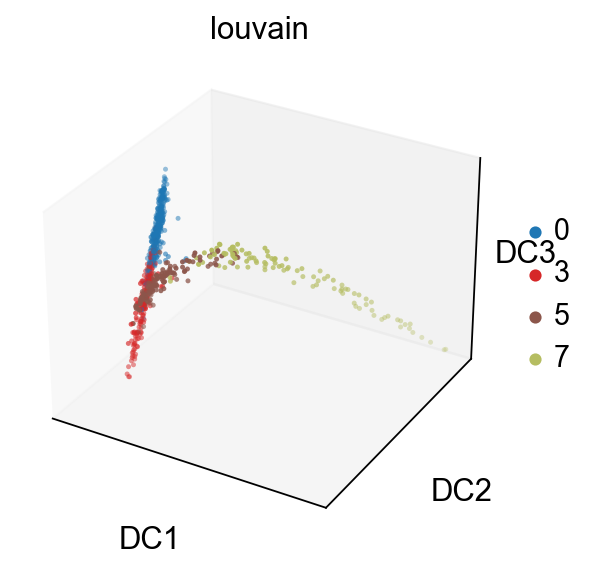

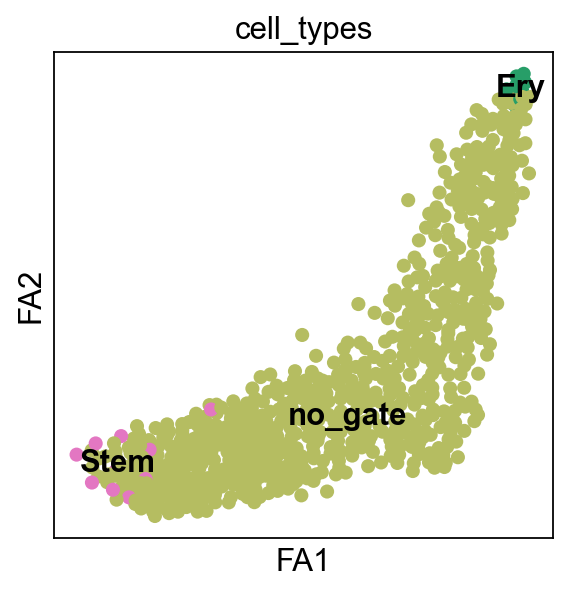

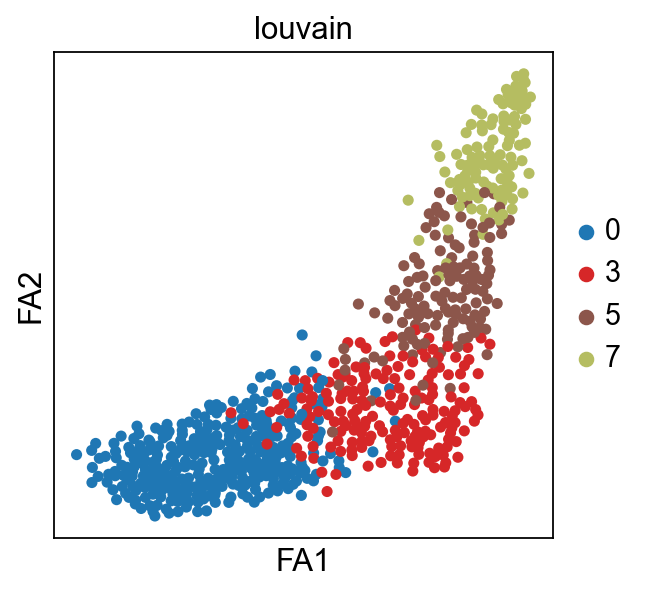

In [27]:
sc.pp.pca(adata_selected_cells, n_comps=50, svd_solver='arpack') # returns the values in obs 'X_pca'
sc.pp.neighbors(adata_selected_cells)#calculate the connectivity graph
sc.tl.umap(adata_selected_cells)
sc.tl.diffmap(adata_selected_cells)
sc.tl.draw_graph(adata_selected_cells)
sc.tl.paga(adata_selected_cells, groups='louvain')

sc.settings.set_figure_params(dpi=80)
sc.pl.pca(adata_selected_cells, color='cell_types', legend_loc='on data')
sc.pl.pca(adata_selected_cells,color='louvain' ,size=50,gene_symbols='gene_id')
sc.pl.umap(adata_selected_cells, color='cell_types', legend_loc='on data')
sc.pl.umap(adata_selected_cells,color='louvain' ,size=100,gene_symbols='gene_id')
sc.pl.diffmap(adata_selected_cells, color='cell_types')
sc.pl.diffmap(adata_selected_cells,color='louvain' ,size=100,gene_symbols='gene_id')
sc.pl.diffmap(adata_selected_cells,color='louvain' ,size=100,gene_symbols='gene_id',projection='3d')
sc.pl.draw_graph(adata_selected_cells, color='cell_types', legend_loc='on data')
sc.pl.draw_graph(adata_selected_cells,color='louvain' ,size=100,gene_symbols='gene_id')


## Slingshot
Inferring the order of cells duting differentiation

In [28]:
adata_ent=adata_selected_cells.copy()
del adata_ent.uns['neighbors']

In [31]:
# choose the embeding model:
X_draw=adata_ent.obsm['X_pca'][:,0:2]

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
     746          2

lineages: 1 
Lineage1: 0  3  5  7  

curves: 1 
Curve1: Length: 67.667	Samples: 746


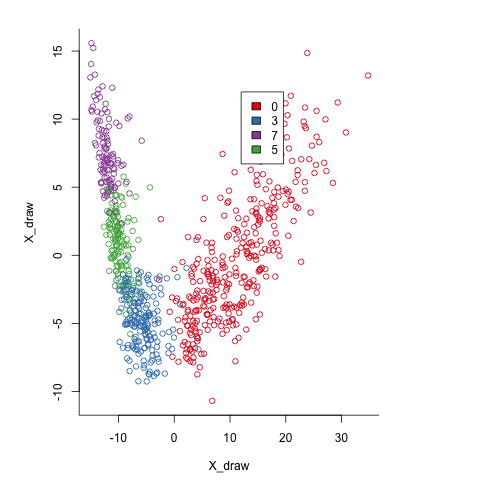

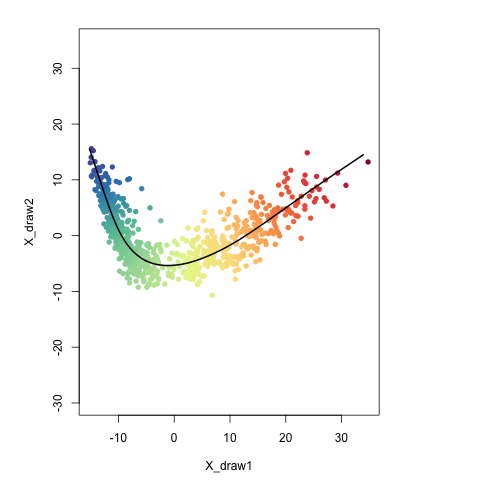

In [37]:
%%R -i adata_ent -i X_draw

reducedDim(adata_ent, "X_draw") <- X_draw

Cluster_labels='louvain'
traj_1_s='0'
#traj_1_e='2'
#traj_2_e='2'

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata_ent)$X_draw[,1], reducedDims(adata_ent)$X_draw[,2], col=colour_map[colData(adata_ent)$louvain], bty='L', xlab='X_draw', ylab='X_draw')
legend(x=12, y=12, legend=unique(colData(adata_ent)$louvain), fill=colour_map[as.integer(unique(colData(adata_ent)$louvain))])

print("1:")
adata_ent_start <- slingshot(adata_ent, clusterLabels = Cluster_labels, reducedDim = 'X_draw', start.clus=traj_1_s)
print(SlingshotDataSet(adata_ent_start))


#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(adata_ent_start)$X_draw[,c(1,2)], col = colors[cut(adata_ent_start$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='X_draw1', ylab='X_draw2')
lines(slingCurves(adata_ent_start)$curve1, lwd=2)

In [38]:
%%R -o slingPseudotime_1
slingPseudotime_1=adata_ent_start$slingPseudotime_1

In [39]:
adata_ent.obs['slingPseudotime_1']=slingPseudotime_1
adata_ent.obs['slingPseudotime_1']

HSPC_002    31.240335
HSPC_017    28.040038
HSPC_020    11.398380
HSPC_035    35.118129
HSPC_047    29.591339
              ...    
Prog_844    51.280789
Prog_849    43.085213
Prog_850    58.235394
Prog_851    45.091794
Prog_852    52.945402
Name: slingPseudotime_1, Length: 746, dtype: float64

### export slingshot results to 1_PT_celltimes.csv (to be used at IQCELL)

In [40]:
# export PT:
Diff_PT=adata_ent.obs['slingPseudotime_1']
Diff_PT=pd.DataFrame(Diff_PT)
Diff_PT.columns=['PT']
Diff_PT.to_csv('1_PT_celltimes.csv')

### export gene expression

 The dataset provided in  [blood.stemcells.cam.ac.uk/single_cell_atlas](http://blood.stemcells.cam.ac.uk/single_cell_atlas) , has fewer genes than the dataset we used in this analysis. Below we load the full dataset and export all genes. This helps us to demonstrate how to select informative genes based on Notebook2. 

In [44]:
#load the full data
adata_full=sc.read_h5ad('Hammey_Blood_Full_data/subsetted_adata.h5')
new_cell_names=[]
for i in list(adata_full.obs.index):
    new_cell_names.append(i.replace('-','.'))
adata_full.obs.index=new_cell_names

cells=list(adata.obs.index)
adata_full=adata_full[cells]

sc.pp.recipe_zheng17(adata_full, log=False,n_top_genes=24876)

pd.DataFrame(pd.DataFrame( list(adata_full.var.index),list(adata_full.var['Accession']) )).to_csv('all_Genes.csv')

running recipe zheng17
filtered out 27978 genes that are detected in less than 1 counts


Trying to set attribute `.var` of view, copying.


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:04)


Below we export the selected cells and their gene expression to '1_exoression_data.csv'

In [45]:
# export the selected cells
Data_to_export=adata_full[list(adata_ent.obs.index),]

scns_gene_list= list(Data_to_export.var.index)

all_gene_names=list(Data_to_export.var.index)
scns_gene_mask= [False]*len(all_gene_names) #making a False mask list of genes then make desired genes True

# making the mask True for the genes in the desired gene list
for i in range(0,len(all_gene_names)):
    if all_gene_names[i] in scns_gene_list:
        scns_gene_mask[i]=True


scns_adata=Data_to_export[:,scns_gene_mask]

scns_Col_names=scns_adata.var_names
scns_Row_names=scns_adata.obs.index

scns_exoression_data=scns_adata.X
scns_exoression_data=np.asarray(scns_exoression_data)
sc.pp.scale(scns_exoression_data)# set mean to zero and variave to 1
scns_exoression_data= pd.DataFrame(scns_exoression_data, columns=scns_Col_names , index=scns_Row_names)
scns_exoression_data=scns_exoression_data.dropna(axis=1)
scns_exoression_data.to_csv('1_exoression_data.csv')


/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:784: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
